<a href="https://colab.research.google.com/github/jshin13/code_bucket/blob/temp/Kaplan_Meier_survivalRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 3: Prognosis and survival functions

In this lab, we will analyze observations from different patients who suffered a heart attack and we will create different survival functions employing univariate (Kaplan-Meier estimate) and multivariate (Cox proportional hazards and survival forests) analysis.

Remember to copy this notebook into your personal folder and suffix your JHID:


*   eg: Lab3_Prognosis_myjhID12

Also, remember to use the MLMA [coding rubric](https://blackboard.jhu.edu/bbcswebdav/pid-9529029-dt-content-rid-99808293_2/courses/EN.520.439.01.SP21/Coding%20rubric_MLMA.pdf).



In [89]:
# Libraries to be used in this lab. Feel free to add more libraries if you need them
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install lifelines
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
!pip install scikit-survival
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

from tqdm.notebook import tqdm
import seaborn as sns

**DATA**

The data that we are going to use in this lab is described in the paper ["Survival analysis of heart failure patients: A case study"](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181001). According to the authors: 

*Current study is based on 299 patients of heart failure comprising of 105 women and 194 men. All the patients were more than 40 years old, having left ventricular systolic dysfunction and falling in NYHA class III and IV. Follow up time was 4–285 days with an average of 130 days. Disease was diagnosed by cardiac echo report or notes written by physician. Age, serum sodium, serum creatinine, gender, smoking, Blood Pressure (BP), Ejection Fraction (EF), anemia, platelets, Creatinine Phosphokinase (CPK) and diabetes were considered as potential variables explaining mortality caused by CHD [...]. The information related to risk factors were taken from blood reports while smoking status and blood pressure were taken from physician’s notes.*






In [90]:
#Load  the data
sData='https://plos.figshare.com/ndownloader/files/8937223'
urllib.request.urlretrieve(sData,'./HeartFailure.csv')
df=pd.read_csv('./HeartFailure.csv')

In [91]:
# Visualize the data and obtain statistics (number of observations and predictor variables)
print('Number of observations: ', len(df))
print('Number of predictor variables: ', len(df.columns)-2)
df.tail()


Number of observations:  299
Number of predictor variables:  11


,TIME,Event,Gender,Smoking,Diabetes,BP,Anaemia,Age,Ejection.Fraction,Sodium,Creatinine,Pletelets,CPK
294,250,0,0,0,1,0,0,45.0,55,132,1.0,543000.0,582
295,244,0,0,0,1,0,0,51.0,40,134,0.9,221000.0,582
296,14,1,1,0,0,0,0,45.0,14,127,0.8,166000.0,582
297,80,0,1,0,1,0,0,60.0,45,133,1.0,297000.0,897
298,16,0,0,0,0,1,1,65.0,25,137,1.3,276000.0,52


# 1. Univariate analysis: Univariate survival functions and cumulative hazard

**TASK 1:** Calculate and plot the survival function employing the Kaplan-Meier estimate  (15 POINTS)

In [4]:
# Calculate and plot the survival function employing the Kaplan-Meier estimate
def calculate_survival_KM(df, TimeColumn, EventColumn):
    """
    Generates a dataframe containing the survival function (time vs probability of survival)
    employing the Kaplan-Meier estimate.
    Inputs: 
        df: input dataframe
        TimeColumn: name of the colum containing the event time
        EventColumn: name of the column indicating if the event happened (1) or not (0)
    Outputs:
        dfSurv: dataframe containing the time and probability of survival
    """
  
    # YOUR CODE GOES HERE
    P = []
    T = np.array(df[TimeColumn].unique())

    for i, t in enumerate(tqdm(T)):
        temp = 1
        P.append([])
        for t_i in T[t >= T]: #Kaplan-Meier multiplication    
            n_i = df.query(f'{EventColumn} == 1 & {TimeColumn} == {t_i}').shape[0]
            N_i = df.query(f'{EventColumn} == 0 & {TimeColumn} >= {t_i}').shape[0]
            temp *= 1-n_i/N_i
        P[i].append(temp)        
    dfSurv = pd.DataFrame(P, columns=['P'])
    dfSurv.index = T

    return dfSurv

def plot_survival(df, TimeColumn, EventColumn, Name):
    """
    This function plots the survival function of the whole df. This function calls
    calculate_survival_KM.
    Inputs: 
        df: input dataframe
        TimeColumn: name of the colum containing the event time
        EventColumn: name of the column indicating if the event happened (1) or not (0)
        Name: legend to be displayed, associated to the survival function
    """

    # YOUR CODE GOES HERE
    P = calculate_survival_KM(df, TimeColumn, EventColumn)
    sns.lineplot(x=P.index, y=P['P'], label=Name)

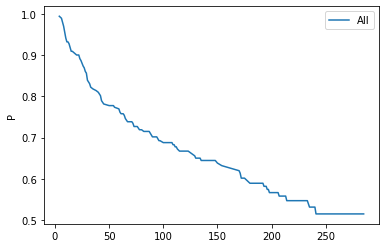

In [5]:
# Plot the survival function obtained with the whole dataframe
TimeColumn='TIME'
EventColumn='Event'
plot_survival(df, TimeColumn, EventColumn, 'All')

**TASK 2:** Code a function that displays the survival function of two categories of a certain predictor (eg. smoker and non-smoker or male, female) in the same plot (10 POINTS).

In [6]:
# function to print two categories 
def plot_survival_twocat(df, predictor, cat1, cat0):
    """
    Displays the survival function of two categories of a certain predictor 
    (eg. smoker and non-smoker or male, female) in the same plot. This function
    only considers binary categories: 0 and 1.
    Inputs:
            df: input dataframe
            predictor: column containing the predictor variable that we want to study
            cat1: Label of the category associated to 1 (eg. Smoker)
            cat0: Label of the category associated to 0 (eg. Non-smoker)
    """
    # YOUR CODE GOES HERE    
    for j, cat in enumerate([cat0, cat1]):
        P = []        
        df_cat = df.query(f'{predictor} == {j}')
        T = np.array(df_cat[TimeColumn].unique())
        for i, t in enumerate(tqdm(T)):
            temp = 1
            P.append([])
            for t_i in T[t >= T]: #Kaplan-Meier multiplication    
                n_i = df_cat.query(f'{EventColumn} == 1 & {TimeColumn} == {t_i}').shape[0]
                N_i = df_cat.query(f'{EventColumn} == 0 & {TimeColumn} >= {t_i}').shape[0]
                temp *= 1-n_i/N_i
            P[i].append(temp)        
        dfSurv = pd.DataFrame(P, columns=['P'])
        dfSurv.index = T

        sns.lineplot(x=dfSurv.index, y=dfSurv['P'], label=cat)

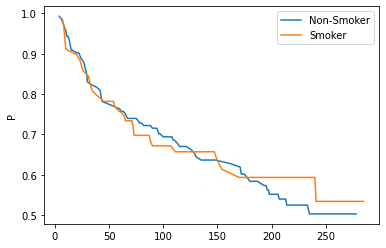

In [7]:
# Plot survival for smokers vs nonsmokers
predictor='Smoking'
cat1='Smoker'
cat0='Non-Smoker'
plot_survival_twocat(df, predictor, cat1, cat0)

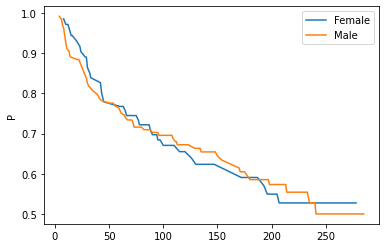

In [8]:
# Plot survival for male vs female (hint: compare your figure with the survival functions
# provided in the original paper; both should be almost identical)
predictor='Gender'
cat1='Male'
cat0='Female'
plot_survival_twocat(df, predictor, cat1, cat0)

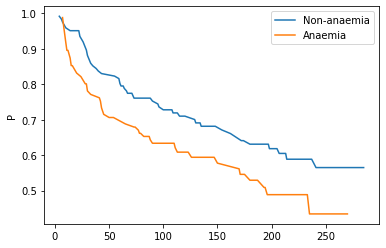

In [9]:
# Plot survival for anaemia vs non-anaemia
predictor='Anaemia'
cat1='Anaemia'
cat0='Non-anaemia'
plot_survival_twocat(df, predictor, cat1, cat0)

Which predictor variable from the previous ones seems to influence the survival probability more?

**TASK 3:** Plot the cumulative Hazard using the Nelson-Aalen estimator (15 Points)

In [10]:
# Plot the cumulative Hazard using the Nelson-Aalen estimator
def cumulative_hazard_NA(df, TimeColumn, EventColumn):
    """
    Generates a dataframe containing the cumulative hazard (H(t)) employing the 
    Nelson-Aalen estimator.
    Inputs: 
            df: input dataframe
            TimeColumn: name of the colum containing the event time
            EventColumn: name of the column indicating if the event happened (1) or not (0)
    Outputs:
            dfH: dataframe containing the time and Cumulative Hazard (H(t))
    """

    # YOUR CODE GOES HERE
    P = []
    T = np.array(df[TimeColumn].unique())

    for i, t in enumerate(tqdm(T)):
        temp = 0
        P.append([])
        for t_i in T[t >= T]: #Kaplan-Meier multiplication    
            n_i = df.query(f'{EventColumn} == 1 & {TimeColumn} == {t_i}').shape[0]
            N_i = df.query(f'{EventColumn} == 0 & {TimeColumn} >= {t_i}').shape[0]
            temp += n_i/N_i
        P[i].append(temp)        
    dfH = pd.DataFrame(P, columns=['P'])
    dfH.index = T

    return dfH

def plot_cumH(df, TimeColumn, EventColumn, Name):
    """
    This function plots the cumulative hazard of the whole df. This function calls
    calculate_hazard_NA.
    Inputs: 
        df: input dataframe
        TimeColumn: name of the colum containing the event time
        EventColumn: name of the column indicating if the event happened (1) or not (0)
        Name: legend to be displayed, associated to the CH
    """

    # YOUR CODE GOES HERE
    P = cumulative_hazard_NA(df, TimeColumn, EventColumn)
    g = sns.lineplot(x=P.index, y=P['P'], label=Name)
    g.set(ylim=(0,1))

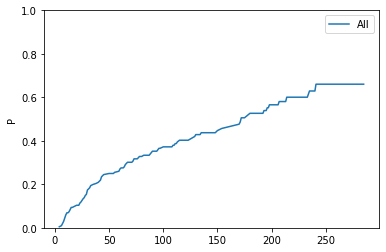

In [11]:
# Plot the cumulative hazard of df
TimeColumn='TIME'
EventColumn='Event'
plot_cumH(df, TimeColumn, EventColumn, 'All')

# 2. Multivariate analysis
**Cox Proportional Hazards**

Now, we are going to employ multivariate analysis using CPH to determine the survival funtions and the hazard ratio of different patients. 
We will employ [lifelines](https://lifelines.readthedocs.io/en/latest/index.html), a python survival analysis library.

**TASK 4:** divide the dataframe into training and testing subsets (5 POINTS).

In [555]:
#Divide the data into training -dfTrain- (80%), and testing -dfTest- (20%):
# YOUR CODE GOES HERE
dfTrain, dfTest = train_test_split(df, train_size=0.8, test_size=0.2)

In [556]:
dfTrain.shape, dfTest.shape

((239, 13), (60, 13))

**TASK 5:** Calculate and print the Cox proportional hazards coefficients of the training subset (dfTrain) (10 POINTS).

In [557]:
# Calculate and print the Cox proportional hazards coefficients

# YOUR CODE GOES HERE
cph = CoxPHFitter()
cph.fit(dfTrain, TimeColumn, EventColumn)
coef = cph.summary['coef']
coef

covariate
Gender              -2.879703e-01
Smoking              1.902460e-01
Diabetes             1.050792e-02
BP                   4.696713e-01
Anaemia              5.315447e-01
Age                  5.059580e-02
Ejection.Fraction   -4.833182e-02
Sodium              -5.845568e-02
Creatinine           2.719814e-01
Pletelets           -6.808820e-07
CPK                  2.215916e-04
Name: coef, dtype: float64

**TASK 6:** Plot the survival function of the three first participants in the test subset (10 POINTS).

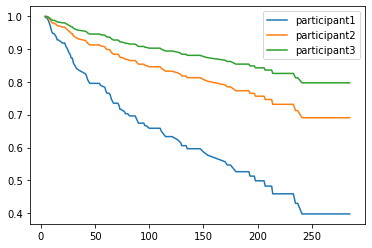

In [558]:
# Plot the survival function of the three first participants in the test subset
participant1=0 # Participant's index in the testing dataframe
participant2=1
participant3=2

# YOUR CODE GOES HERE
for i in range(3):
    y = cph.predict_survival_function(dfTest.iloc[i,2:])
    y.index = y.index.astype(int)

    g = sns.lineplot(x=y.index, y=y.iloc[:,0], label=f'participant{i+1}')
    g.set(ylabel='')

As you can observe, the survival functions are proportional

**TASK 7:** Create a function that calculates the hazard ratio between two patients. This will tell us which of the two patients is at a higher risk (10 POINTS).

In [559]:
# Create a function that calculates the hazard ratio between two patients. This will tell us which patient is at a higher risk.
def hazard_ratio(df, participant1, participant2, cph):
    '''
    Calculates the hazard ratio of participant1 vs participant 2 using
    the coefficients of the CPH model.
    
    Inputs:
        df: dataframe containing all the participants of the study subset
        participant1: index of the first participant in the df.
        participant2: index of the second participant in the df.
        cph: CPH model obtained with lifelines
    Outputs:
        HR: hazard ratio of participant 1 vs participant 2
    '''
    # YOUR CODE GOES HERE
    coef = np.array(cph.summary['coef'].tolist())
    p1   = np.array(df.iloc[participant1][2:].tolist()) #exclude time and label
    p2   = np.array(df.iloc[participant2][2:].tolist()) #exclude time and label

    theta1 = np.exp(np.sum(coef * p1))
    theta2 = np.exp(np.sum(coef * p2))

    HR = theta1 / theta2

    return HR

In [560]:
print('Participant 1 vs participant 2 Hazard Ratio: ' + str(hazard_ratio(df, 2, 33, cph)))

Participant 1 vs participant 2 Hazard Ratio: 4.73717448836902


**TASK 8:** Create a function to calculate the concordance index of the CPH model already trained, employing the testing data (20 POINTS).

In [561]:
# concordance index function
def c_index_mlma(df, TimeColumn, EventColumn, cph):
    '''
    Computes the C-Index employing the testing data and trained models.
    
    Inputs: 
      df: input dataframe
      TimeColumn: name of the colum containing the event time
      EventColumn: name of the column indicating if the event happened (1) or not (0)
      cph: CPH model obtained with lifelines
    Outputs:
      CI: Concordance Index
    '''
    
    # YOUR CODE GOES HERE

    N = df.shape[0] #total sample size
    cd = 0 #concordance
    dc = 0 #concordance + disconcordance
    tie = 0 #ties

    for i in tqdm(range(N)):
        for j in range(i+1, N):
            hz = hazard_ratio(df, i, j, cph) #compute hazard between i and j
            t  = df.iloc[i][TimeColumn] >= df.iloc[j][TimeColumn] #conditional on time
            dj = (df.iloc[j][EventColumn] == 1)*1 #cencored

            cd += 1*(t)*(hz < 1)*dj #concordance is 1 if h(j) is higher and j is not censored
            dc += 1*(t)*dj #denominator
            tie += 0.5*(hz == 1) #tie

    CI = (cd + tie) / dc #CI equation

    return CI   

In [564]:
# Concordance Index of the training data
TimeColumn='TIME'
EventColumn='Event'
CI=c_index_mlma(dfTrain, TimeColumn, EventColumn, cph)
print(CI)


0.7401640483803698


In [563]:
# The result sholud be similar to the CI calculated by the lifelines library (+/- 0.015)
print(cph.concordance_index_)

0.7579953609334364


In [565]:
# Concordance Index of the testing data
TimeColumn='TIME'
EventColumn='Event'
CI=c_index_mlma(dfTest, TimeColumn, EventColumn, cph)
print(CI)


0.5368421052631579


**Survival forests**

Now, we are going to use a different type of multivariate analysis to calculate survival functions: Random Survival Forests. To perform this type of analysis, we will employ the [scikit-survival library](https://scikit-survival.readthedocs.io/en/stable/index.html). 


**TASK 9:** Train a random survival forest using the training subset (15 POINTS).

In [566]:
# YOUR CODE GOES HERE
rsf = RandomSurvivalForest()#n_estimators=200)
X = dfTrain.iloc[:,2:].to_numpy()
y = sksurv.util.Surv.from_dataframe(event='Event', time='TIME', data=dfTrain.iloc[:,:2])

rsf.fit(X,y)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=3,
                     min_samples_split=6, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

**TASK 10:** Calculate the C-I of the model when applied to the testing subset. Use the scikit-survival scoring functions to obtain the index. Compare this result with the C-I obtained with the CPH models (5 POINTS).

In [567]:
# YOUR CODE GOES HERE
X = dfTest.iloc[:,2:].to_numpy()
y = sksurv.util.Surv.from_dataframe(event='Event', time='TIME', data=dfTest.iloc[:,:2])
rsf.score(X, y)

0.5869191049913941

**TASK 11:** Plot the survival function of the three first patients in the testing subset. Compare these survival functions with those obtained with the CPH models (15 POINTS).

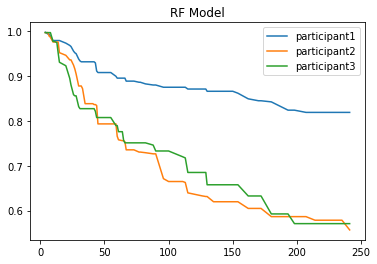

In [568]:
# YOUR CODE GOES HERE
X = dfTest.iloc[:3,2:].to_numpy() #first 3 patients, excluding labels
plot = rsf.predict_survival_function(X, return_array=False) #getting survival functions for each patient
for i in range(3):
    g = sns.lineplot(x=plot[i].x, y=plot[i].y, label=f'participant{i+1}') #line plot
    g.set(title='RF Model')

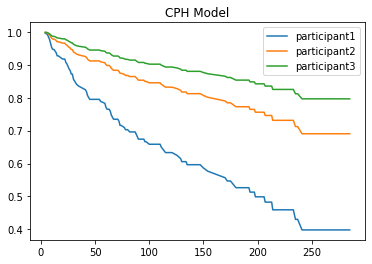

In [569]:
for i in range(3):
    y = cph.predict_survival_function(dfTest.iloc[i,2:])
    y.index = y.index.astype(int)

    g = sns.lineplot(x=y.index, y=y.iloc[:,0], label=f'participant{i+1}')
    g.set(ylabel='', title='CPH Model')

As you can observe, these functions are not proportional. Their shape depends on the predictor variables of each patient.

**TASK 12:** Execute the following cell to finish the lab (1 POINT)

In [331]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/CNjggrxUQ78" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


**Congratulations!! You have finished Lab 3!!**